In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from generator import RoadNetwork, Trajectory
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pandas as pd
import networkx as nx
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import osmnx as ox
from models import GTNModel, GTCModel, Traj2VecModel, GAEModel, GCNEncoder, Node2VecModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns
import umap
import umap.plot

In [2]:
network = RoadNetwork()
network.load("../osm_data/porto")

data_roadclf = network.generate_road_segment_pyg_dataset(include_coords=True, drop_labels=["highway_enc"], traj_data=None)
data_rest = network.generate_road_segment_pyg_dataset(include_coords=True, traj_data=None)

In [3]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = GTNModel(data_roadclf, device, network)
model.load_model("../models/model_states/gtn/model_noroad_porto.pt")

n2v = Node2VecModel(data_rest, device=device)
n2v.load_model("../models/model_states/node2vec/model_base_porto.pt")

gae = GAEModel(data_roadclf, device=device, encoder=GCNEncoder, emb_dim=128)
gae.load_model("../models/model_states/gaegcn/model_noroad_porto.pt")

In [4]:
emb = model.load_emb()[2:]
n2v_emb = n2v.load_emb()
gae_emb = gae.load_emb()
# pca = PCA(n_components=2)
# reduc_gtn = pca.fit_transform(emb)
reduc_gtn = TSNE(n_components=2, learning_rate=200, init='pca', perplexity=30, n_iter=1000, verbose=0, random_state=69).fit_transform(emb)
reduc_n2v = TSNE(n_components=2, learning_rate=200, init='pca', perplexity=30, n_iter=1000, verbose=0, random_state=69).fit_transform(n2v_emb)
reduc_gae = TSNE(n_components=2, learning_rate=200, init='pca', perplexity=30, n_iter=1000, verbose=0, random_state=69).fit_transform(gae_emb)

y_road = np.array([network.gdf_edges.loc[n]["highway"] for n in network.line_graph.nodes])

In [59]:
tf = pd.read_csv("../datasets/trajectories/Porto/speed_features_unnormalized.csv")
tf.set_index(["u", "v", "key"], inplace=True)
map_id = {j: i for i, j in enumerate(network.line_graph.nodes)}
tf["idx"] = tf.index.map(map_id)
tf.sort_values(by="idx", axis=0, inplace=True)
y = tf["avg_speed"]
y.fillna(0, inplace=True)
y_speed = y.round(2)
y_speed = pd.cut(y_speed, bins=11, labels=[f'{i} km/h' if i < 100 else f'{i}+ km/h'for i in range(0, 110, 10)])

In [8]:
reduc_gtn_umap = umap.UMAP(n_neighbors=15).fit_transform(emb)
reduc_gtn_n2v = umap.UMAP(n_neighbors=15).fit_transform(n2v_emb)
# umap.plot.points(mapper, labels=y_road)

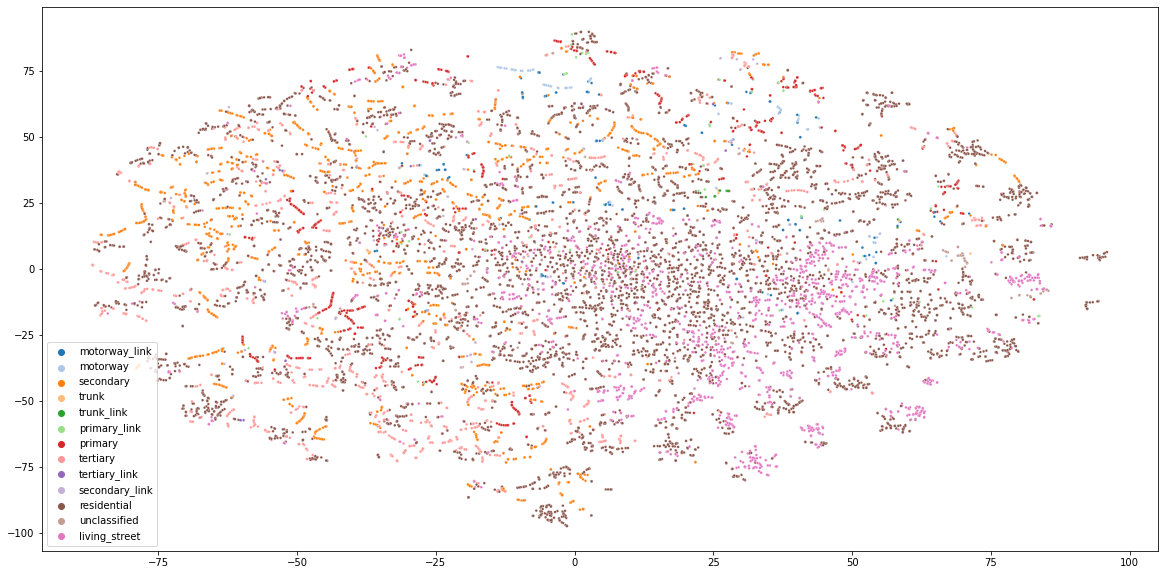

In [5]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

pal = sns.color_palette("tab20", as_cmap=True)
# visualization
f, ax = plt.subplots(1, 1, figsize=(20, 10))
#sns.scatterplot(reduc_gtn_umap[:, 0], reduc_gtn_umap[:, 1], hue=y_road, palette="tab20", ax=ax[0], s=7)
sns.scatterplot(reduc_gtn[:, 0], reduc_gtn[:, 1], hue=y_road, palette="tab20", ax=ax, s=7)
plt.legend(loc='lower left')

# axins = zoomed_inset_axes(ax, 8, loc=1) # zoom = 6
# # axins.scatter(reduc_gtn[:, 0], reduc_gtn[:, 1], c=pal)
# sns.scatterplot(reduc_gtn[:, 0], reduc_gtn[:, 1], hue=y_road, palette="tab20", ax=axins, s=20, legend=False)

# # sub region of the original image
# x1, x2, y1, y2 = 52, 57, 9, 14
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)

# plt.xticks(visible=False)
# plt.yticks(visible=False)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

In [8]:
from models.utils import generate_trajid_to_nodeid
# plot trajectories in embedding
traj = Trajectory(f"../datasets/trajectories/porto/road_segment_map_final.csv", nrows=100000).generate_TTE_datatset()
traj_map = generate_trajid_to_nodeid(network)

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/100000 [00:00<?, ?it/s]

In [56]:
from enum import unique
from platform import node


colors = np.full(reduc_gtn.shape[0], -1)
node_indices = []
node_org_ids = list(network.line_graph.nodes)
highway_decode = pd.Series(network.gdf_edges.highway.values, index=network.gdf_edges.highway_enc).to_dict()
highway_decode[-1] = "unlabeled"
sample = traj.sample(n=1)
for i, seq in enumerate(sample.seg_seq):
    node_indices.append([])
    for id in seq:
        colors[traj_map[id]] = network.gdf_edges.iloc[id]["highway_enc"]
        node_indices[i].append(node_org_ids[traj_map[id]])

graph = network.G.edge_subgraph(list(node_indices[0]))

str_colors = sns.color_palette("tab20")
palette = {highway_decode[int(c)]: "darkgrey" if c==-1 else str_colors[int(c)] for c in np.unique(colors)}
sizes = [1 if c==-1 else 2 for c in colors]

graph_colors = []
scatter_colors = []
for i, c in enumerate(colors):
    # if c > -1:
    #     edge_id = node_org_ids[i]
    #     graph_colors[edge_id] = str_colors[int(c)]
    # convert colors to match palette
    scatter_colors.append(highway_decode[c])

for e in graph.edges:
    # get pos in line graph
    pos = node_org_ids.index(e)
    graph_colors.append(str_colors[int(colors[pos])] if colors[pos] > -1 else "darkgrey" )
        
graph_colors = pd.Series(graph_colors)

print(len(sample.seg_seq.values[0]), sample.index)

38 Int64Index([68640], dtype='int64')


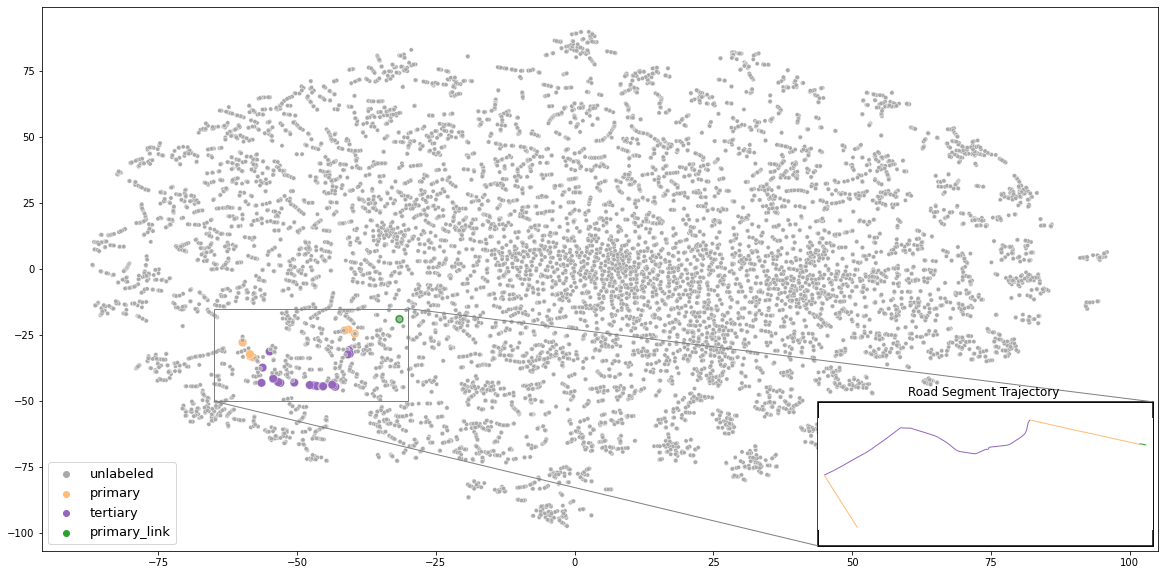

In [63]:
import folium
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

f, ax = plt.subplots(1, 1, figsize=(20, 10))
#sns.scatterplot(reduc_gtn_umap[:, 0], reduc_gtn_umap[:, 1], hue=y_road, palette="tab20", ax=ax[0], s=7)
g = sns.scatterplot(reduc_gtn[:, 0], reduc_gtn[:, 1], hue=scatter_colors, palette=palette, ax=ax, s=7, size=sizes)

h,l = g.get_legend_handles_labels()
uc = np.unique(scatter_colors).shape[0]
plt.legend(h[0:uc],l[0:uc], loc="lower left", fontsize=13)

axins = inset_axes(ax, width="30%", height=2, loc=4) # zoom = 6
axins.axes.get_xaxis().set_visible(False)
axins.axes.get_yaxis().set_visible(False)
axins2 = inset_axes(ax, width="30%", height=2, loc=4)
axins.patch.set_edgecolor('black')  
axins.patch.set_linewidth('1.5')
axins.set_title("Road Segment Trajectory ")
# axins.scatter(reduc_gtn[:, 0], reduc_gtn[:, 1], c=pal)
# sns.scatterplot(reduc_gtn[:, 0], reduc_gtn[:, 1], hue=y_road, palette="tab20", ax=axins, s=20, legend=False)

# sub region of the original image
x1, x2, y1, y2 = -65, -30, -50, -15
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

plt.xticks(visible=False)
plt.yticks(visible=False)

# draw a bbox of the region of the inset axes in the parent axes and
# connecting lines between the bbox and the inset axes area
mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

_, axr = ox.plot_graph(graph, ax=axins2, node_size=0, bgcolor = 'white', edge_color=graph_colors)